# Project Introduction

Welcome to my project! In this project, I will be analyzing the orthologs of two genes: SNCA (Alpha-synuclein) and LRRK2 (Leucine-rich repeat kinase 2). Orthologs are genes in different species that evolved from a common ancestral gene.

## Objective

The main objective of this project is to study the evolutionary relationships and sequence conservation of SNCA and LRRK2 genes across different species. By analyzing the orthologs of these genes, we can gain insights into their functional importance and evolutionary history.

## Workflow

1. Retrieving Orthologs: We will start by retrieving the orthologs of SNCA and LRRK2 genes from a provided CSV file. These orthologs contain information such as gene ID, gene symbol, species, reference sequence ID, and protein ID.

2. Gene Sequence Retrieval: Next, we will fetch the gene sequences from the NCBI database for each ortholog. If the sequence is not already saved, we will save it in a folder called "gene_sequences".

3. Genome Window Locator: We will restrict the area for alignment on the genome by performing local alignments using the Smith-Waterman algorithm. This will help us focus on specific regions of the genome that are relevant to our analysis.

4. Multiple Protein Alignment: Using the ClustalW algorithm, we will perform multiple alignments for each gene on all genomes. This will allow us to compare the amino acid sequences of orthologs and identify conserved regions.

5. Phylogenetic Tree Construction: We will construct phylogenetic trees using the aligned sequences to visualize the evolutionary relationships between the orthologs. The trees will be created using the PhyML algorithm.

6. Visualization: Finally, we will visualize the phylogenetic trees and analyze the results. We will assign random colors to each clade in the tree and display branch lengths as labels.

## Conclusion

By analyzing the orthologs of SNCA and LRRK2 genes and constructing phylogenetic trees, we aim to gain a better understanding of their evolutionary history and sequence conservation. This project will provide valuable insights into the functional importance of these genes across different species.

Stay tuned for the exciting results and visualizations in the upcoming sections!


In [71]:
from Bio.Align import PairwiseAlignments
def Genome_Window_Locator(gene, genome, match_score:int, gap_penalty:int, substitution_matrix:str=None)->list[PairwiseAlignments]:
    """restrict the area for alignment on the genome"""
    from numpy import argmax
    from Bio.Align import substitution_matrices,PairwiseAligner
    aligner=PairwiseAligner()
    if substitution_matrix:
        aligner.substitution_matrix = substitution_matrices.load(substitution_matrix)
    aligner.gap_score=gap_penalty
    aligner.match_score = match_score
    aligner.mode = 'local'
    gene=gene.seq
    genome=genome.seq
    genomeWindow=1000
    geneWindow=100
    scores=[]
    for genome_idx in range(0,len(genome),genomeWindow):
        window_alignment=aligner.align(gene[:geneWindow],genome[genome_idx:genome_idx+genomeWindow])
        scores.append(window_alignment.score)
    genome_start_idx=(argmax(scores)-1)*genomeWindow
    if genome_start_idx<0: 
        genome_start_idx=0
    genome_end_idx=genome_start_idx+len(gene)*2
    local_alignment=aligner.align(gene,genome[genome_start_idx:genome_end_idx])

    gneome_window_restrictions=[local_alignment[0].aligned[1][0][0]+genome_start_idx,local_alignment[0].aligned[1][-1][-1]+genome_start_idx]# window start index,  window end index
    
    genome_window_loaction_for_alignment=genome[gneome_window_restrictions[0]:gneome_window_restrictions[1]]
    return genome_window_loaction_for_alignment

def Prepare_Multi_Sequence_Alignemnt_File(gene_id:str,genome_id:str, sequence:str, details:str=None):
    with open(f".\{'alignments'}\{gene_id}.fasta", "a") as f:
        f.write(f">{genome_id} {details}\n{sequence}\n".replace(' ','_'))
    return True

def Creating_Multiple_Protein_Alignment_File(orthologs:dict,related_genomes_file:str)->dict:
    """
    Performs local alignments using the Smith-Waterman algorithm for each gene on all genomes.
    And create alignment files for each gene.
    """
    from csv import reader
    genome_ids=[]
    with open(related_genomes_file, 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            genome_ids.append((row[0],row[1]))

    from Bio import SeqIO
    for genome_id,genome_detail in genome_ids:
        for SNCA_gene_id,SNCA_ortolog_genes in orthologs.items():
            # creating multiple alignment file
            genome_sequence=Genome_Window_Locator(
                gene=SNCA_ortolog_genes.get_gene_sequence(),
                genome=SeqIO.read(f".\genomes\{genome_id}.fasta", "fasta"),
                match_score=1,
                gap_penalty=-10,
            )
            Prepare_Multi_Sequence_Alignemnt_File(
                gene_id=SNCA_gene_id,
                genome_id=genome_id,
                sequence=genome_sequence.translate(),
                details=genome_detail
            )
    return True


In [72]:
def Multiple_Alignment_With_ClustalW(fasta_filename:str, output_filename:str)->None:
    from Bio.Align.Applications import ClustalwCommandline
    clustalw_runner = ClustalwCommandline(".\clustalw2", infile=fasta_filename, outfile=output_filename)
    stdout, stderr = clustalw_runner()
    if stderr:
        raise Exception(stderr)
    return True

def Perform_Alignment_For_Each_Gene(orthologs:dict)->dict:
    """
    Performs multiple alignments using the ClustalW algorithm for each gene on all genomes.
    """
    for SNCA_gene_id,_ in orthologs.items():
        # creating multiple alignment file
        Multiple_Alignment_With_ClustalW(
            fasta_filename=f".\{'alignments'}\{SNCA_gene_id}.fasta",
            output_filename=f".\{'alignments'}\{SNCA_gene_id}.aln"
        )
    return True


In [73]:
from Bio.AlignIO import MultipleSeqAlignment
def Phylogenetice_Tree_Maker(multiple_sequence_alignemnt:MultipleSeqAlignment,gene_name:str):
    from Bio.Phylo.Applications import PhymlCommandline
    from Bio import AlignIO
    phylip_file_name=f".\{'trees'}\multi_sequence_alignment_of_SNCA_{gene_name}.phylip"
    with open(phylip_file_name,'w') as outfile:
        AlignIO.write(multiple_sequence_alignemnt,outfile,format="phylip")
    phylogenetic_tree_runner = PhymlCommandline(
        cmd='.\PhyML-3.1_win32.exe',
        input=phylip_file_name,datatype='aa')#aa -> amino acid / nt -> nulceutide
    stdout, stderr = phylogenetic_tree_runner()
    if stderr: raise Exception(stderr)
    return stdout

def Read_Multiple_Sequence_Alignment_From_File(filename:str)->MultipleSeqAlignment:
    from Bio.AlignIO import read
    file_handler = open(filename,"r")
    multiple_sequence_alignemnt = read(file_handler, "clustal")
    file_handler.close()
    return multiple_sequence_alignemnt

def SNCA_Phylogenetic_Tree_Maker(orthologs:dict)->None:
    for SNCA_gene_id,_ in orthologs.items():
        Phylogenetice_Tree_Maker(gene_name=SNCA_gene_id,multiple_sequence_alignemnt=Read_Multiple_Sequence_Alignment_From_File(filename=f".\{'alignments'}\{SNCA_gene_id}.aln"))



In [74]:
def random_color():
    from random import randint
    return tuple(randint(50, 200) for _ in range(3))

def Visualize_Phylogenetic_Tree(phylogenetic_tree_file_name:str):
    from Bio import Phylo
    phylo_tree_file = open (phylogenetic_tree_file_name,"r")
    tree = Phylo.read(phylo_tree_file, format="newick").as_phyloxml()
    for clade in tree.clade:
        clade.color = random_color()
    phylo_tree_file.close()
    # Phylo.draw_ascii(tree)# with strings
    Phylo.draw(tree,branch_labels=lambda clade: float(round(clade.branch_length or 0,2)))# visualize by image

def Visualize_Phylogenetic_Tree_For_Each_Gene(orthologs:dict)->None:
    for SNCA_gene_id,_ in orthologs.items():
        print(f".\{'trees'}\multi_sequence_alignment_of_SNCA_{SNCA_gene_id}.phy_phyml_tree.txt")
        Visualize_Phylogenetic_Tree(phylogenetic_tree_file_name=f".\{'trees'}\multi_sequence_alignment_of_SNCA_{SNCA_gene_id}.phylip_phyml_tree.txt")


In [75]:
def SNCA_Runner():# SNCA -> Alpha-synuclein gene
    orthologs=Retrieve_Orthologs_data(orthologs_csv_file=".\SNCA_orthologs.csv")
    Creating_Multiple_Protein_Alignment_File(orthologs=orthologs,related_genomes_file="SNCA_related_genomes.csv")
    Perform_Alignment_For_Each_Gene(orthologs=orthologs)
    SNCA_Phylogenetic_Tree_Maker(orthologs=orthologs)
    Visualize_Phylogenetic_Tree_For_Each_Gene(orthologs=orthologs)

def LRRK2_Runner():# LRRK2 -> Leucine-rich repeat kinase 2 gene
    orthologs=Retrieve_Orthologs_data(orthologs_csv_file=".\LRRK2_orthologs.csv")
    Creating_Multiple_Protein_Alignment_File(orthologs=orthologs,related_genomes_file="LRRK2_related_genomes.csv")
    Perform_Alignment_For_Each_Gene(orthologs=orthologs)
    SNCA_Phylogenetic_Tree_Maker(orthologs=orthologs)
    Visualize_Phylogenetic_Tree_For_Each_Gene(orthologs=orthologs)

.\trees\multi_sequence_alignment_of_SNCA_120892.phy_phyml_tree.txt


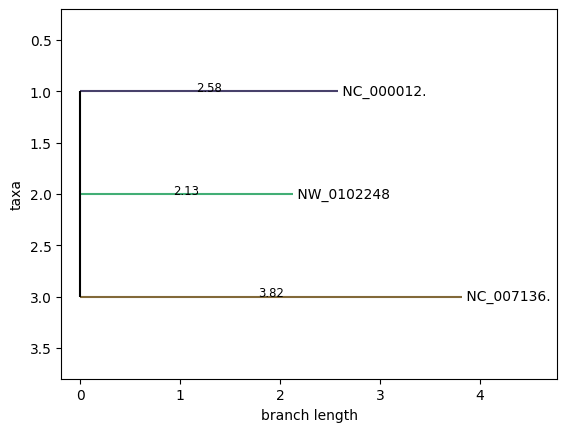

.\trees\multi_sequence_alignment_of_SNCA_6622.phy_phyml_tree.txt


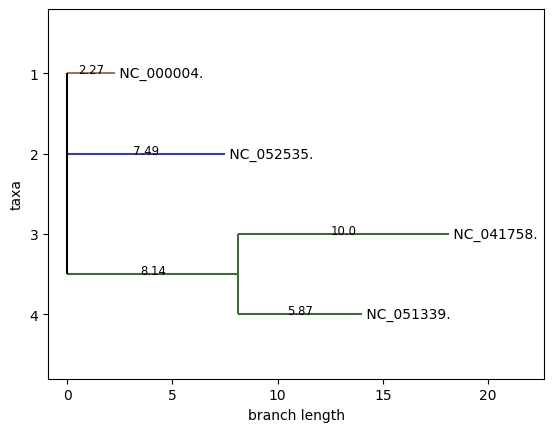

In [79]:
LRRK2_Runner()# perform the analysis for LRRK2 gene
SNCA_Runner()# perform the analysis for SNCA gene
